## Part1


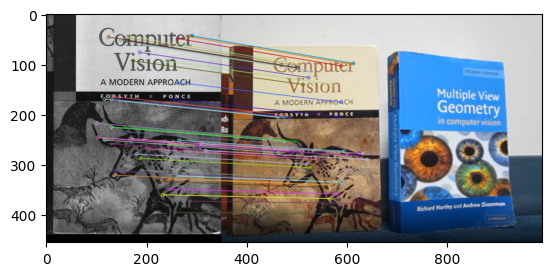

In [1]:
import cv2
import matplotlib.pyplot as plt

book_img = cv2.imread('cv_cover.jpg')
frame_img = cv2.imread('frame0.png')
gray_frame = cv2.cvtColor(frame_img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(book_img, None) #encoding gradients patterns around each kjeypoint
kp2, des2 = sift.detectAndCompute(gray_frame, None)

bf = cv2.BFMatcher() #braute force to cumpute distance between each 2 descriptors 
matches = bf.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

good = sorted(good, key=lambda x: x.distance)[:50]

matched_img = cv2.drawMatches(book_img, kp1, frame_img, kp2, good, None, flags=2)
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.show()


##### what is a homography?

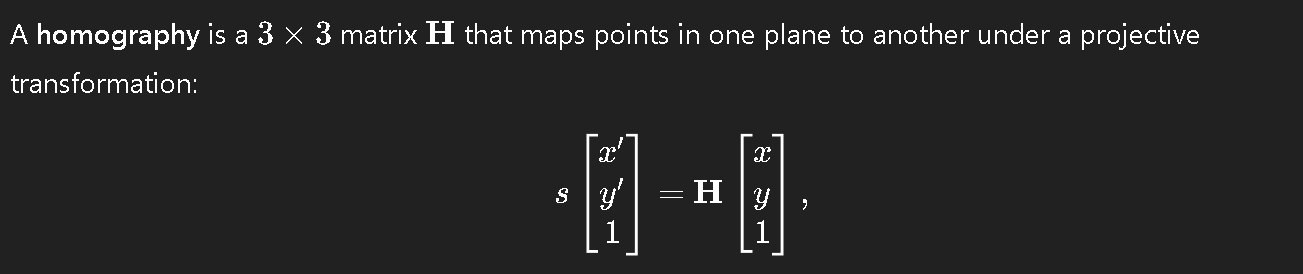

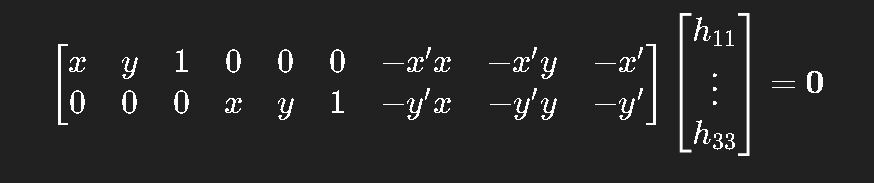

In [2]:
# comput homgraphy
import numpy as np

# 1. Extract the matched point coordinates
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

# 2. Compute 3×3 homography H mapping src→dst, using RANSAC
H, mask = cv2.findHomography(src_pts, dst_pts,
                             method=cv2.RANSAC,
                             ransacReprojThreshold=3)
print(f"the homography matrix is: \n{H}")

#Compute homography manually
import numpy as np

def compute_homography(source_poiints, destination_points):
    
    if source_poiints.shape != destination_points.shape or source_poiints.shape[0] < 4:
        raise ValueError("There must be at least 4 pairs of corresponding points and shapes must match.")

    n = source_poiints.shape[0]
    A = []

    for i in range(n):
        x, y = source_poiints[i]
        x_prime, y_prime = destination_points[i]

        A.append([-x, -y, -1,  0,  0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([ 0,  0,  0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    A = np.array(A)
    # Solve using SVD
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3) #i am interested in the last row

    # Normalize so that H[2,2] == 1
    return H / H[-1, -1]

src_flat=pts_flat = src_pts.reshape(-1, 2)
dst_flat=pts_flat = dst_pts.reshape(-1, 2)


H_manual=compute_homography(src_flat,dst_flat)
print(f"\n the manual homography matrix is \n{H_manual}")

the homography matrix is: 
[[ 8.86150086e-01 -6.28555688e-03  1.05880455e+01]
 [ 1.35819531e-03  8.32583663e-01  6.37660526e+01]
 [ 8.00082836e-05 -8.35222786e-05  1.00000000e+00]]

 the manual homography matrix is 
[[ 8.85045461e-01 -6.42886224e-03  1.07064158e+01]
 [ 6.69403083e-04  8.31818474e-01  6.38987989e+01]
 [ 7.74299495e-05 -8.42146191e-05  1.00000000e+00]]


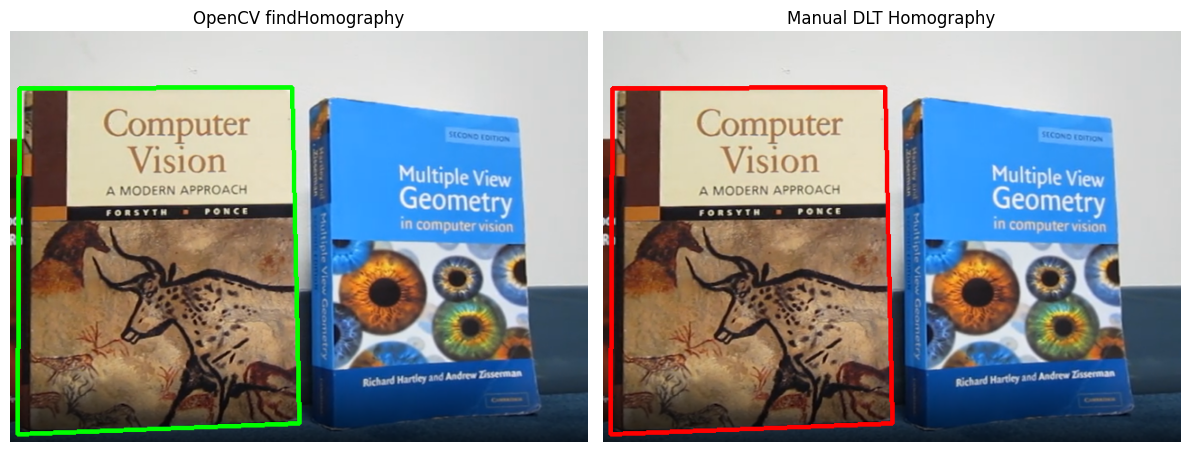

In [3]:
#calculate book coordinates

# 1. Define corners of the book image in its own frame
h, w = book_img.shape[:2]
book_corners = np.float32([[0,0], [w,0], [w,h], [0,h]]).reshape(-1,1,2)

# 2. Map those corners into the video frame
mapped_corners = cv2.perspectiveTransform(book_corners, H)
mapped_corners_manual=cv2.perspectiveTransform(book_corners, H_manual)
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 1. Create two separate annotated frames
frame_opencv = frame_img.copy()
cv2.polylines(
    frame_opencv,
    [np.int32(mapped_corners)],
    isClosed=True,
    color=(0, 255, 0),    # green
    thickness=3
)

frame_manual = frame_img.copy()
cv2.polylines(
    frame_manual,
    [np.int32(mapped_corners_manual)],
    isClosed=True,
    color=(0, 0, 255),    # red
    thickness=3
)

# 2. Plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# OpenCV result
axes[0].imshow(cv2.cvtColor(frame_opencv, cv2.COLOR_BGR2RGB))
axes[0].set_title('OpenCV findHomography')
axes[0].axis('off')

# Manual DLT result
axes[1].imshow(cv2.cvtColor(frame_manual, cv2.COLOR_BGR2RGB))
axes[1].set_title('Manual DLT Homography')
axes[1].axis('off')

plt.tight_layout()
plt.show()



In [4]:
#crop ar video frame
# distance between corner 0→1 = width on book in frame
target_w = int(np.linalg.norm(mapped_corners[0] - mapped_corners[1]))
# distance between corner 0→3 = height on book in frame
target_h = int(np.linalg.norm(mapped_corners[0] - mapped_corners[3]))
ar_frame = cv2.imread('ar_frame0.png')
h0, w0 = ar_frame.shape[:2]
# compute cropping offsets to center
desired_aspect = target_w / target_h
curr_aspect    = w0 / h0

if curr_aspect > desired_aspect:
    # too wide → crop left/right
    new_w = int(desired_aspect * h0)
    offset = (w0 - new_w)//2
    crop = ar_frame[:, offset:offset+new_w]
else:
    # too tall → crop top/bottom
    new_h = int(w0 / desired_aspect)
    offset = (h0 - new_h)//2
    crop = ar_frame[offset:offset+new_h, :]
resized_ar = cv2.resize(crop, (target_w, target_h))


[[ 1.03040707e+00 -7.23990605e-03  1.05880451e+01]
 [ 1.57929585e-03  9.58996894e-01  6.37660522e+01]
 [ 9.30328723e-05 -9.62036065e-05  1.00000000e+00]]

[[ 1.13568253e+00  7.32068312e-03 -1.24914693e+01]
 [ 5.07400895e-03  1.19991842e+00 -7.65677848e+01]
 [-9.04402172e-05  9.96342051e-05  1.00000000e+00]]


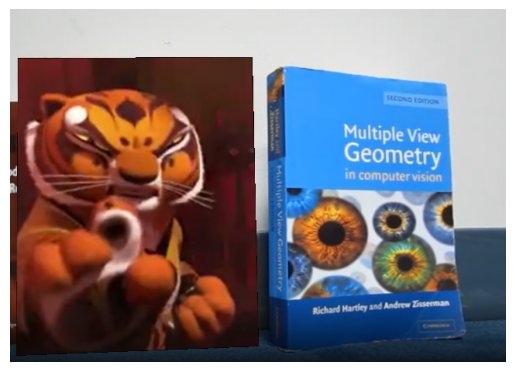

: 

In [ ]:
# 1. Compute warp from the cropped AR frame into the book quadrilateral
src_corners = np.float32([[0,0], [target_w,0], [target_w,target_h], [0,target_h]])
H_warp = cv2.getPerspectiveTransform(src_corners, mapped_corners.reshape(4,2))
print(H_warp)
H_book2frame = np.linalg.inv(H)
print(f"\n{H_book2frame/H_book2frame[-1,-1]}")#H / H[-1, -1]
# 2. Warp the AR image onto the size of the video frame
warped_ar = cv2.warpPerspective(resized_ar,
                                H_warp,
                                (frame_img.shape[1], frame_img.shape[0]))
# 3. Create a mask and blend
mask = np.zeros_like(frame_img, dtype=np.uint8)#blacked out image frame 
cv2.fillConvexPoly(mask,
                   np.int32(mapped_corners),
                   (255,255,255))#fill ROI white
inv_mask = cv2.bitwise_not(mask)# inverted mask
plt.imshow(inv_mask)
# 4. Zero‑out the book region in original frame
background = cv2.bitwise_and(frame_img, inv_mask)
# 5. Insert warped AR in that region
result = cv2.bitwise_or(background, warped_ar)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


video pre-processing

In [43]:
import cv2
import numpy as np

def remove_black_bars(input_path, output_path, threshold=30):
    """Remove top/bottom black bars from video and save cleaned version."""
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Get crop region from first frame
    ret, frame = cap.read()
    if not ret:
        raise ValueError("Can't read video")
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    row_sums = np.sum(gray, axis=1)
    
    # Detect top crop (first non-black row)
    top = 0
    while top < height and row_sums[top] <= threshold * width:
        top += 1
    
    # Detect bottom crop (last non-black row)
    bottom = height - 1
    while bottom >= 0 and row_sums[bottom] <= threshold * width:
        bottom -= 1
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, bottom - top + 1))
    
    # Process all frames
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cleaned_frame = frame[top:bottom+1, :]  # Crop top/bottom
        out.write(cleaned_frame)
    
    cap.release()
    out.release()

# Usage
remove_black_bars("ar_source.mov", "ar_source_cleaned.mp4")

In [47]:
import cv2
import numpy as np

# ——————————————————————————————
# 1. Prepare static data: book cover and SIFT matcher

book_img      = cv2.imread('cv_cover.jpg')
book_h, book_w = book_img.shape[:2]
book_aspect   = book_w / book_h

# Precompute keypoints/descriptors on the static book cover
sift      = cv2.SIFT_create()
kp_book, des_book = sift.detectAndCompute(book_img, None)

bf = cv2.BFMatcher()

# Helper: center‑crop an image to a target aspect ratio
def crop_to_aspect(img, target_aspect):
    h, w = img.shape[:2]
    curr_aspect = w / h
    if curr_aspect > target_aspect:
        # too wide → crop left/right
        new_w = int(target_aspect * h)
        x0    = (w - new_w) // 2
        return img[:, x0:x0+new_w]
    else:
        # too tall → crop top/bottom
        new_h = int(w / target_aspect)
        y0    = (h - new_h) // 2
        return img[y0:y0+new_h, :]

# ——————————————————————————————
# 2. Open videos and set up writer

cap_book = cv2.VideoCapture('book.mov')
cap_ar   = cv2.VideoCapture('ar_source_cleaned.mp4')

# Read first frame to get size & fps
ret_b, first_book = cap_book.read()
assert ret_b, "Cannot read book.mov"
h_frame, w_frame = first_book.shape[:2]
fps = cap_book.get(cv2.CAP_PROP_FPS) or 30

fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('output.avi',
                         fourcc,
                         fps,
                         (w_frame, h_frame))
assert writer.isOpened(), "Failed to open VideoWriter"

# Rewind capture to first frame
cap_book.set(cv2.CAP_PROP_POS_FRAMES, 0)
cap_ar.set(  cv2.CAP_PROP_POS_FRAMES, 0)

# ——————————————————————————————
# 3. Main loop: process frame-by-frame

while True:
    ret_b, frame_b = cap_book.read()
    ret_a, frame_a = cap_ar.read()
    if not (ret_b and ret_a):
        break

    # A) Detect current book keypoints
    gray_b = cv2.cvtColor(frame_b, cv2.COLOR_BGR2GRAY)
    kp_b, des_b = sift.detectAndCompute(gray_b, None)
    matches = bf.knnMatch(des_book, des_b, k=2)

    # B) Lowe’s ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    if len(good) < 4:
        # Not enough matches → skip AR for this frame
        writer.write(frame_b)
        continue

    # C) Solve homography book→current frame
    src_pts = np.float32([kp_book[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_b[m.trainIdx].pt     for m in good]).reshape(-1,1,2)
    H_book, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

    # D) Map the 4 book corners into this frame
    book_corners = np.float32([[0,0], [book_w,0], [book_w,book_h], [0,book_h]]).reshape(-1,1,2)
    mapped_corners = cv2.perspectiveTransform(book_corners, H_book)

    # E) Crop AR frame to book aspect, then resize to book’s pixel size
    cropped = crop_to_aspect(frame_a, book_aspect)
    resized_ar = cv2.resize(cropped, (book_w, book_h))

    # F) Warp the resized AR into the detected quadrilateral
    src_quad = np.float32([[0,0], [book_w,0], [book_w,book_h], [0,book_h]])
    H_ar2frame = cv2.getPerspectiveTransform(src_quad, mapped_corners.reshape(4,2))
    warped_ar = cv2.warpPerspective(resized_ar,
                                    H_ar2frame,
                                    (w_frame, h_frame))

    # G) Blend: mask out the book region, then add warped AR
    mask = np.zeros((h_frame, w_frame), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(mapped_corners), 255)
    mask_color = cv2.merge([mask, mask, mask])

    background = cv2.bitwise_and(frame_b,  cv2.bitwise_not(mask_color))
    overlay    = cv2.bitwise_and(warped_ar, mask_color)
    result     = cv2.add(background, overlay)

    # H) Write blended frame
    writer.write(result)

# ——————————————————————————————
# 4. Cleanup
writer.release()
cap_book.release()
cap_ar.release()
